In [2]:
%load_ext autoreload
%autoreload 2
import os 
os.environ["HF_HOME"] = "/tmp/wendler/hf_cache"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import sys
sys.path.append('/share/u/wendler/code/my-sdxl-unbox')

In [3]:
n = 100
path_to_checkpoints = '../hparam_study/'#'../checkpoints/'#'../hparam_study/'
k = 20
exp = 4
n_timesteps = 4
use_vanilla = False
dtype="fp32"
batch_size = 16

In [4]:
outfile = f"timestep_generalization_n{n}_t{n_timesteps}_{'vanilla' if use_vanilla else 'turbo'}_k{k}_exp{exp}.csv"

In [5]:
n_feats = exp * 1280

In [6]:
import os
import gradio as gr
import torch
from SDLens import HookedStableDiffusionXLPipeline
from SAE import SparseAutoencoder
from app import create_demo
assert torch.cuda.is_available(), "Your machine has no access to GPU. If you are using Colab, consider changing environment"
# The SAEs were trained to work with torch.float32, but they can also work with torch.float16
# Change this value to torch.float32 if you have access to a GPU with >30GB of memory
if dtype == "fp32":
    dtype = torch.float32
else:
    dtype = torch.float16

sdxl_turbo = "stabilityai/sdxl-turbo" 
sdxl = "stabilityai/stable-diffusion-xl-base-1.0"
if not use_vanilla:
    model_name = sdxl_turbo 
else:
    model_name = sdxl

pipe = HookedStableDiffusionXLPipeline.from_pretrained(
    model_name,
    torch_dtype=dtype,
    device_map="balanced",
    variant=("fp16" if dtype==torch.float16 else None)
)
pipe.set_progress_bar_config(disable=True)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [7]:
model_name

'stabilityai/sdxl-turbo'

In [8]:
code_to_block = {
    "down.2.1": "unet.down_blocks.2.attentions.1",
    "mid.0": "unet.mid_block.attentions.0",
    "up.0.1": "unet.up_blocks.0.attentions.1",
    "up.0.0": "unet.up_blocks.0.attentions.0"
}

saes_dict = {}
means_dict = {}

for code, block in code_to_block.items():
    sae = SparseAutoencoder.load_from_disk(
        os.path.join(path_to_checkpoints, f"{block}_k{k}_hidden{n_feats}_auxk256_bs4096_lr0.0001", "final"),
    )
    saes_dict[code] = sae.to('cuda', dtype=dtype)

In [9]:
import numpy as np
from matplotlib import pyplot as plt
import json
if n > 5:
    with open('/tmp/wendler/first_50K_prompts.json', 'r') as f:
        prompts = json.load(f)
    prompts = [p["caption"] for p in prompts[n:2*n]]
else:
    prompts = [
        "A photo of a cat",
        "A photo of a dog",
        "A photo of a bird",
        "A photo of a fish",
        "A photo of a horse",
    ]

In [10]:
prompts

['An industrial style chandelier with several bulbs.',
 'A dining room with art on the wall.',
 'A set of stainless steel pots and pans.',
 'sunflowers in the field with a blue sky and clouds',
 "A woman's face in the dark on a black laptop sleeve.",
 'A young boy wearing glasses and a superman shirt.',
 'Two fish tacos on a blue plate.',
 'A garden with an elevated water feature.',
 'Several pictures showing different types and sizes of steel structure',
 'A group of people holding up signs with red writing.',
 'Mardi Gras items on display in a store.',
 'The Eiffel tower is shown in this photo.',
 'Four people sitting on a bench with laptops.',
 'A woman with clay on her face and hands.',
 'The logo for Greens Power products.',
 'A person holding two gold pineapple charms.',
 'A white napkin with a small square on it.',
 'The balcony has a view of Miami Harbor.',
 'An older man with glasses and a blue shirt smiling',
 'A woman in red corset and black skirt.',
 'An open ring with a fl

In [11]:
# find out the models inside of pipe
if dtype == torch.float32:
    pipe.text_encoder.to(dtype=torch.float32)
    pipe.text_encoder_2.to(dtype=torch.float32)

In [12]:
from collections import defaultdict
for short, sae in saes_dict.items():
    print(short, sae.path)

down.2.1 ../hparam_study/unet.down_blocks.2.attentions.1_k20_hidden5120_auxk256_bs4096_lr0.0001/final
mid.0 ../hparam_study/unet.mid_block.attentions.0_k20_hidden5120_auxk256_bs4096_lr0.0001/final
up.0.1 ../hparam_study/unet.up_blocks.0.attentions.1_k20_hidden5120_auxk256_bs4096_lr0.0001/final
up.0.0 ../hparam_study/unet.up_blocks.0.attentions.0_k20_hidden5120_auxk256_bs4096_lr0.0001/final


In [ ]:
sys.path.append('/share/u/wendler/code/my-sdxl-unbox/scripts')
from train_sae import explained_variance
from tqdm import tqdm
from einops import einsum, rearrange
verbose = False
results = defaultdict(list)
guidance_scale = 0.0 if not use_vanilla else 7.5
# make a dataloader
from torch.utils.data import DataLoader
dataloader = DataLoader(prompts, batch_size=batch_size, shuffle=False)
for pidx, batch in enumerate(tqdm(dataloader)):
    output, cache = pipe.run_with_cache(
        batch,
        positions_to_cache=list(code_to_block.values()),
        save_input=True,
        save_output=True,
        num_inference_steps=n_timesteps,
        guidance_scale=guidance_scale,
        generator=torch.Generator(device="cpu").manual_seed(42)
    )
    timesteps = pipe.scheduler.timesteps
    if verbose:
        plt.imshow(output.images[0])
        plt.show()
    #for short, long in code_to_block.items():
    for short, sae in saes_dict.items():
        long = code_to_block[short]
        diff = cache['output'][long] - cache['input'][long]
        if diff.shape[0] == 2*batch_size:
            diff_uncond, diff_cond = diff.chunk(2)
            diffs = [diff_uncond, diff_cond]
        else:
            diffs = [diff]
        for cfg_idx, diff in enumerate(diffs):
            print(diff.shape,"diff")
            # timesteps x features x height x width
            print(short, sae.path)
            assert long in sae.path, f"long {long} not in sae.path {sae.path}"
            sae.eval()
            diff_perm = rearrange(diff, "b t f h w -> b t h w f")
            # timesteps x height x width x features
            diff_flat = rearrange(diff_perm, "b t h w f -> (b t h w) f")
            # (timesteps * height * width) x features
            recon, info = sae(diff_flat)
            # (timesteps * height * width) x features
            l2_1 = ((diff_flat - recon)**2).sum(dim=-1).mean()
            features = sae.encode(diff_perm)
            # timesteps x height x width x features
            recon_perm = features @ sae.decoder.weight.T + sae.pre_bias
            l2_2 = ((diff_perm - recon_perm)**2).sum(dim=-1).mean()
            # they should be similar
            assert abs(l2_1 - l2_2) < 1e-2, f"l2_1 != l2_2: {l2_1} != {l2_2}"
            fnormalized = features / features.norm(dim=-1, keepdim=True)
            dnormalized = diff_perm / diff_perm.norm(dim=-1, keepdim=True)
            fnormalized = features / features.norm(dim=-1, keepdim=True)
            dnormalized = diff_perm / diff_perm.norm(dim=-1, keepdim=True)
            fbinarized = (features > 0).float()
            fdots = einsum(fnormalized[:, :-1], fnormalized[:, 1:], "b t h w f, b t h w f -> b t h w").mean(dim=0).mean(dim=1).mean(dim=1)
            dots = einsum(dnormalized[:, :-1], dnormalized[:, 1:], "b t h w f, b t h w f -> b t h w").mean(dim=0).mean(dim=1).mean(dim=1)
            fdots_binarized = einsum(fbinarized[:, :-1], fbinarized[:, 1:], "b t h w f, b t h w f -> b t h w") # == intersection 
            
            # union next
            fdots_union = (fbinarized[:, :-1] + fbinarized[:, 1:]).clamp(0, 1).sum(dim=-1)
            iou = fdots_binarized / fdots_union
            iou_mean = iou.mean(dim=0).mean(dim=1).mean(dim=1)
            recon = rearrange(recon, "(b t h w) f -> t (b h w) f", b=len(batch), t=len(timesteps), h=diff.shape[3], w=diff.shape[4])
            # timesteps x (height * width) x features
            for idx in range(diff.shape[1]):
                tmp = rearrange(diff[:, idx], "b f h w -> (b h w) f")
                # expects n x features
                explained_var = explained_variance(tmp, recon[idx])
                if cfg_idx == 0:
                    results["block"].append(short)
                    results["tidx"].append(idx)
                    results["t"].append(timesteps[idx].item())
                results[f"explained_var_{cfg_idx}"].append(explained_var.item())
                
                if idx == diff.shape[1] - 1:
                    results[f"fdots_{cfg_idx}"].append(0.0)
                    results[f"dots_{cfg_idx}"].append(0.0)
                    results[f"iou_{cfg_idx}"].append(0.0)
                else:
                    results[f"fdots_{cfg_idx}"].append(fdots[idx].item())
                    results[f"dots_{cfg_idx}"].append(dots[idx].item())
                    results[f"iou_{cfg_idx}"].append(iou_mean[idx].item())
                
from pandas import DataFrame
df = DataFrame(results)
df.to_csv(outfile)
df

  0%|          | 0/7 [00:00<?, ?it/s]

torch.Size([16, 4, 1280, 16, 16]) diff
down.2.1 ../hparam_study/unet.down_blocks.2.attentions.1_k20_hidden5120_auxk256_bs4096_lr0.0001/final
torch.Size([3]) torch.Size([3]) torch.Size([3])
torch.Size([4, 4096, 1280])
torch.Size([16, 4, 1280, 16, 16]) diff.shape 4
torch.Size([16, 1280, 16, 16])
torch.Size([16, 4, 1280, 16, 16]) diff.shape 4
torch.Size([16, 1280, 16, 16])
torch.Size([16, 4, 1280, 16, 16]) diff.shape 4
torch.Size([16, 1280, 16, 16])
torch.Size([16, 4, 1280, 16, 16]) diff.shape 4
torch.Size([16, 1280, 16, 16])
torch.Size([16, 4, 1280, 16, 16]) diff
mid.0 ../hparam_study/unet.mid_block.attentions.0_k20_hidden5120_auxk256_bs4096_lr0.0001/final
torch.Size([3]) torch.Size([3]) torch.Size([3])
torch.Size([4, 4096, 1280])
torch.Size([16, 4, 1280, 16, 16]) diff.shape 4
torch.Size([16, 1280, 16, 16])
torch.Size([16, 4, 1280, 16, 16]) diff.shape 4
torch.Size([16, 1280, 16, 16])
torch.Size([16, 4, 1280, 16, 16]) diff.shape 4
torch.Size([16, 1280, 16, 16])
torch.Size([16, 4, 1280, 16

 14%|█▍        | 1/7 [00:07<00:47,  7.91s/it]

torch.Size([3]) torch.Size([3]) torch.Size([3])
torch.Size([4, 4096, 1280])
torch.Size([16, 4, 1280, 16, 16]) diff.shape 4
torch.Size([16, 1280, 16, 16])
torch.Size([16, 4, 1280, 16, 16]) diff.shape 4
torch.Size([16, 1280, 16, 16])
torch.Size([16, 4, 1280, 16, 16]) diff.shape 4
torch.Size([16, 1280, 16, 16])
torch.Size([16, 4, 1280, 16, 16]) diff.shape 4
torch.Size([16, 1280, 16, 16])
torch.Size([16, 4, 1280, 16, 16]) diff
up.0.0 ../hparam_study/unet.up_blocks.0.attentions.0_k20_hidden5120_auxk256_bs4096_lr0.0001/final
torch.Size([3]) torch.Size([3]) torch.Size([3])
torch.Size([4, 4096, 1280])
torch.Size([16, 4, 1280, 16, 16]) diff.shape 4
torch.Size([16, 1280, 16, 16])
torch.Size([16, 4, 1280, 16, 16]) diff.shape 4
torch.Size([16, 1280, 16, 16])
torch.Size([16, 4, 1280, 16, 16]) diff.shape 4
torch.Size([16, 1280, 16, 16])
torch.Size([16, 4, 1280, 16, 16]) diff.shape 4
torch.Size([16, 1280, 16, 16])
torch.Size([16, 4, 1280, 16, 16]) diff
down.2.1 ../hparam_study/unet.down_blocks.2.atte

 29%|██▊       | 2/7 [00:16<00:40,  8.10s/it]

torch.Size([3]) torch.Size([3]) torch.Size([3])
torch.Size([4, 4096, 1280])
torch.Size([16, 4, 1280, 16, 16]) diff.shape 4
torch.Size([16, 1280, 16, 16])
torch.Size([16, 4, 1280, 16, 16]) diff.shape 4
torch.Size([16, 1280, 16, 16])
torch.Size([16, 4, 1280, 16, 16]) diff.shape 4
torch.Size([16, 1280, 16, 16])
torch.Size([16, 4, 1280, 16, 16]) diff.shape 4
torch.Size([16, 1280, 16, 16])
torch.Size([16, 4, 1280, 16, 16]) diff
up.0.0 ../hparam_study/unet.up_blocks.0.attentions.0_k20_hidden5120_auxk256_bs4096_lr0.0001/final
torch.Size([3]) torch.Size([3]) torch.Size([3])
torch.Size([4, 4096, 1280])
torch.Size([16, 4, 1280, 16, 16]) diff.shape 4
torch.Size([16, 1280, 16, 16])
torch.Size([16, 4, 1280, 16, 16]) diff.shape 4
torch.Size([16, 1280, 16, 16])
torch.Size([16, 4, 1280, 16, 16]) diff.shape 4
torch.Size([16, 1280, 16, 16])
torch.Size([16, 4, 1280, 16, 16]) diff.shape 4
torch.Size([16, 1280, 16, 16])
torch.Size([16, 4, 1280, 16, 16]) diff
down.2.1 ../hparam_study/unet.down_blocks.2.atte

 43%|████▎     | 3/7 [00:24<00:33,  8.40s/it]

torch.Size([3]) torch.Size([3]) torch.Size([3])
torch.Size([4, 4096, 1280])
torch.Size([16, 4, 1280, 16, 16]) diff.shape 4
torch.Size([16, 1280, 16, 16])
torch.Size([16, 4, 1280, 16, 16]) diff.shape 4
torch.Size([16, 1280, 16, 16])
torch.Size([16, 4, 1280, 16, 16]) diff.shape 4
torch.Size([16, 1280, 16, 16])
torch.Size([16, 4, 1280, 16, 16]) diff.shape 4
torch.Size([16, 1280, 16, 16])
torch.Size([16, 4, 1280, 16, 16]) diff
up.0.0 ../hparam_study/unet.up_blocks.0.attentions.0_k20_hidden5120_auxk256_bs4096_lr0.0001/final
torch.Size([3]) torch.Size([3]) torch.Size([3])
torch.Size([4, 4096, 1280])
torch.Size([16, 4, 1280, 16, 16]) diff.shape 4
torch.Size([16, 1280, 16, 16])
torch.Size([16, 4, 1280, 16, 16]) diff.shape 4
torch.Size([16, 1280, 16, 16])
torch.Size([16, 4, 1280, 16, 16]) diff.shape 4
torch.Size([16, 1280, 16, 16])
torch.Size([16, 4, 1280, 16, 16]) diff.shape 4
torch.Size([16, 1280, 16, 16])
torch.Size([16, 4, 1280, 16, 16]) diff
down.2.1 ../hparam_study/unet.down_blocks.2.atte

 57%|█████▋    | 4/7 [00:33<00:26,  8.67s/it]

torch.Size([3]) torch.Size([3]) torch.Size([3])
torch.Size([4, 4096, 1280])
torch.Size([16, 4, 1280, 16, 16]) diff.shape 4
torch.Size([16, 1280, 16, 16])
torch.Size([16, 4, 1280, 16, 16]) diff.shape 4
torch.Size([16, 1280, 16, 16])
torch.Size([16, 4, 1280, 16, 16]) diff.shape 4
torch.Size([16, 1280, 16, 16])
torch.Size([16, 4, 1280, 16, 16]) diff.shape 4
torch.Size([16, 1280, 16, 16])
torch.Size([16, 4, 1280, 16, 16]) diff
up.0.0 ../hparam_study/unet.up_blocks.0.attentions.0_k20_hidden5120_auxk256_bs4096_lr0.0001/final
torch.Size([3]) torch.Size([3]) torch.Size([3])
torch.Size([4, 4096, 1280])
torch.Size([16, 4, 1280, 16, 16]) diff.shape 4
torch.Size([16, 1280, 16, 16])
torch.Size([16, 4, 1280, 16, 16]) diff.shape 4
torch.Size([16, 1280, 16, 16])
torch.Size([16, 4, 1280, 16, 16]) diff.shape 4
torch.Size([16, 1280, 16, 16])
torch.Size([16, 4, 1280, 16, 16]) diff.shape 4
torch.Size([16, 1280, 16, 16])
torch.Size([16, 4, 1280, 16, 16]) diff
down.2.1 ../hparam_study/unet.down_blocks.2.atte

 71%|███████▏  | 5/7 [00:43<00:17,  8.94s/it]

torch.Size([16, 4, 1280, 16, 16]) diff.shape 4
torch.Size([16, 1280, 16, 16])
torch.Size([16, 4, 1280, 16, 16]) diff.shape 4
torch.Size([16, 1280, 16, 16])
torch.Size([16, 4, 1280, 16, 16]) diff.shape 4
torch.Size([16, 1280, 16, 16])
torch.Size([16, 4, 1280, 16, 16]) diff
up.0.0 ../hparam_study/unet.up_blocks.0.attentions.0_k20_hidden5120_auxk256_bs4096_lr0.0001/final
torch.Size([3]) torch.Size([3]) torch.Size([3])
torch.Size([4, 4096, 1280])
torch.Size([16, 4, 1280, 16, 16]) diff.shape 4
torch.Size([16, 1280, 16, 16])
torch.Size([16, 4, 1280, 16, 16]) diff.shape 4
torch.Size([16, 1280, 16, 16])
torch.Size([16, 4, 1280, 16, 16]) diff.shape 4
torch.Size([16, 1280, 16, 16])
torch.Size([16, 4, 1280, 16, 16]) diff.shape 4
torch.Size([16, 1280, 16, 16])
torch.Size([16, 4, 1280, 16, 16]) diff
down.2.1 ../hparam_study/unet.down_blocks.2.attentions.1_k20_hidden5120_auxk256_bs4096_lr0.0001/final
torch.Size([3]) torch.Size([3]) torch.Size([3])
torch.Size([4, 4096, 1280])
torch.Size([16, 4, 1280,

 86%|████████▌ | 6/7 [00:52<00:09,  9.13s/it]

torch.Size([16, 4, 1280, 16, 16]) diff.shape 4
torch.Size([16, 1280, 16, 16])
torch.Size([16, 4, 1280, 16, 16]) diff.shape 4
torch.Size([16, 1280, 16, 16])
torch.Size([16, 4, 1280, 16, 16]) diff.shape 4
torch.Size([16, 1280, 16, 16])
torch.Size([16, 4, 1280, 16, 16]) diff
up.0.0 ../hparam_study/unet.up_blocks.0.attentions.0_k20_hidden5120_auxk256_bs4096_lr0.0001/final
torch.Size([3]) torch.Size([3]) torch.Size([3])
torch.Size([4, 4096, 1280])
torch.Size([16, 4, 1280, 16, 16]) diff.shape 4
torch.Size([16, 1280, 16, 16])
torch.Size([16, 4, 1280, 16, 16]) diff.shape 4
torch.Size([16, 1280, 16, 16])
torch.Size([16, 4, 1280, 16, 16]) diff.shape 4
torch.Size([16, 1280, 16, 16])
torch.Size([16, 4, 1280, 16, 16]) diff.shape 4
torch.Size([16, 1280, 16, 16])


100%|██████████| 7/7 [00:55<00:00,  7.93s/it]

torch.Size([4, 4, 1280, 16, 16]) diff
down.2.1 ../hparam_study/unet.down_blocks.2.attentions.1_k20_hidden5120_auxk256_bs4096_lr0.0001/final
torch.Size([3]) torch.Size([3]) torch.Size([3])
torch.Size([4, 1024, 1280])
torch.Size([4, 4, 1280, 16, 16]) diff.shape 4
torch.Size([4, 1280, 16, 16])
torch.Size([4, 4, 1280, 16, 16]) diff.shape 4
torch.Size([4, 1280, 16, 16])
torch.Size([4, 4, 1280, 16, 16]) diff.shape 4
torch.Size([4, 1280, 16, 16])
torch.Size([4, 4, 1280, 16, 16]) diff.shape 4
torch.Size([4, 1280, 16, 16])
torch.Size([4, 4, 1280, 16, 16]) diff
mid.0 ../hparam_study/unet.mid_block.attentions.0_k20_hidden5120_auxk256_bs4096_lr0.0001/final
torch.Size([3]) torch.Size([3]) torch.Size([3])
torch.Size([4, 1024, 1280])
torch.Size([4, 4, 1280, 16, 16]) diff.shape 4
torch.Size([4, 1280, 16, 16])
torch.Size([4, 4, 1280, 16, 16]) diff.shape 4
torch.Size([4, 1280, 16, 16])
torch.Size([4, 4, 1280, 16, 16]) diff.shape 4
torch.Size([4, 1280, 16, 16])
torch.Size([4, 4, 1280, 16, 16]) diff.shape

,block,tidx,t,explained_var_0,fdots_0,dots_0,iou_0
0,down.2.1,0,999.0,0.680936,0.658328,0.731565,0.289963
1,down.2.1,1,749.0,0.517830,0.587934,0.698854,0.251699
2,down.2.1,2,499.0,0.246664,0.641877,0.791304,0.318639
3,down.2.1,3,249.0,0.007132,0.000000,0.000000,0.000000
4,mid.0,0,999.0,0.448712,0.296688,0.495924,0.117049
...,...,...,...,...,...,...,...
107,up.0.1,3,249.0,0.230028,0.000000,0.000000,0.000000
108,up.0.0,0,999.0,0.415921,0.539480,0.667310,0.244539
109,up.0.0,1,749.0,0.392316,0.514664,0.663172,0.244192
110,up.0.0,2,499.0,0.330366,0.549250,0.729111,0.279597


In [14]:
df.groupby(["block", "tidx"]).mean().reset_index()

,block,tidx,t,explained_var_0,fdots_0,dots_0,iou_0
0,down.2.1,0,999.0,0.671936,0.642791,0.724290,0.284139
1,down.2.1,1,749.0,0.482515,0.619664,0.735206,0.274621
2,down.2.1,2,499.0,0.189476,0.638758,0.792105,0.316129
3,down.2.1,3,249.0,-0.085685,0.000000,0.000000,0.000000
4,mid.0,0,999.0,0.461101,0.307595,0.498636,0.119409
5,mid.0,1,749.0,0.228850,0.330154,0.561034,0.145995
6,mid.0,2,499.0,-0.105017,0.371213,0.646678,0.182202
7,mid.0,3,249.0,-0.460092,0.000000,0.000000,0.000000
8,up.0.0,0,999.0,0.528933,0.536658,0.694261,0.249108
9,up.0.0,1,749.0,0.494072,0.595504,0.751557,0.299569


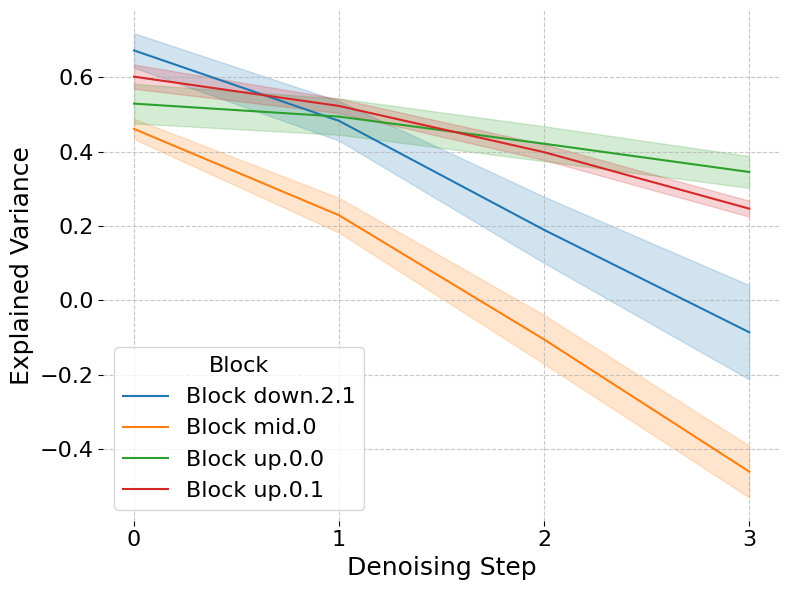

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Get the number of cfg indices
cfg_indices = []
if use_vanilla:
    cfg_indices = [0, 1]  # Only get cfg indices when use_vanilla is true
else:
    cfg_indices = [0]

# Create a separate figure for each cfg_idx
for cfg_idx in cfg_indices:
    # Create a new figure for each cfg_idx
    plt.figure(figsize=(8, 6))
    ax = plt.gca()
    
    # Group by block and tidx to get mean and std of explained variance for this cfg_idx
    var_col = f"explained_var_{cfg_idx}"
    summary_df = df.groupby(["block", "tidx"])[var_col].agg(['mean', 'std']).reset_index()
    
    # Remove border
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    blocks = summary_df['block'].unique()
    colors = sns.color_palette(n_colors=len(blocks))
    
    for i, block in enumerate(blocks):
        block_df = summary_df[summary_df['block'] == block]
        ax.plot(block_df['tidx'], block_df['mean'], label=f"Block {block}", color=colors[i])
        # Gaussian confidence interval: mean ± 1.96*std
        lower = block_df['mean'] - 1.96 * block_df['std']/np.sqrt(len(block_df))
        upper = block_df['mean'] + 1.96 * block_df['std']/np.sqrt(len(block_df))
        ax.fill_between(block_df['tidx'], lower, upper, color=colors[i], alpha=0.2)
    
    # Add gridlines
    ax.grid(True, linestyle='--', alpha=0.7)
    
    # Increase font size
    ax.set_xlabel("Denoising Step", fontsize=18)
    ax.set_ylabel("Explained Variance", fontsize=18)
    ax.legend(title="Block", loc='lower left', fontsize=16, title_fontsize=16)
    # they should be just 1 apart
    ax.set_xticks(block_df['tidx'])
    ax.tick_params(axis='both', which='major', labelsize=16)
    plt.tight_layout()
    plt.savefig(f"{outfile.replace('.csv', '')}_explained_variance_cfg_{cfg_idx}.pdf")
    plt.show()

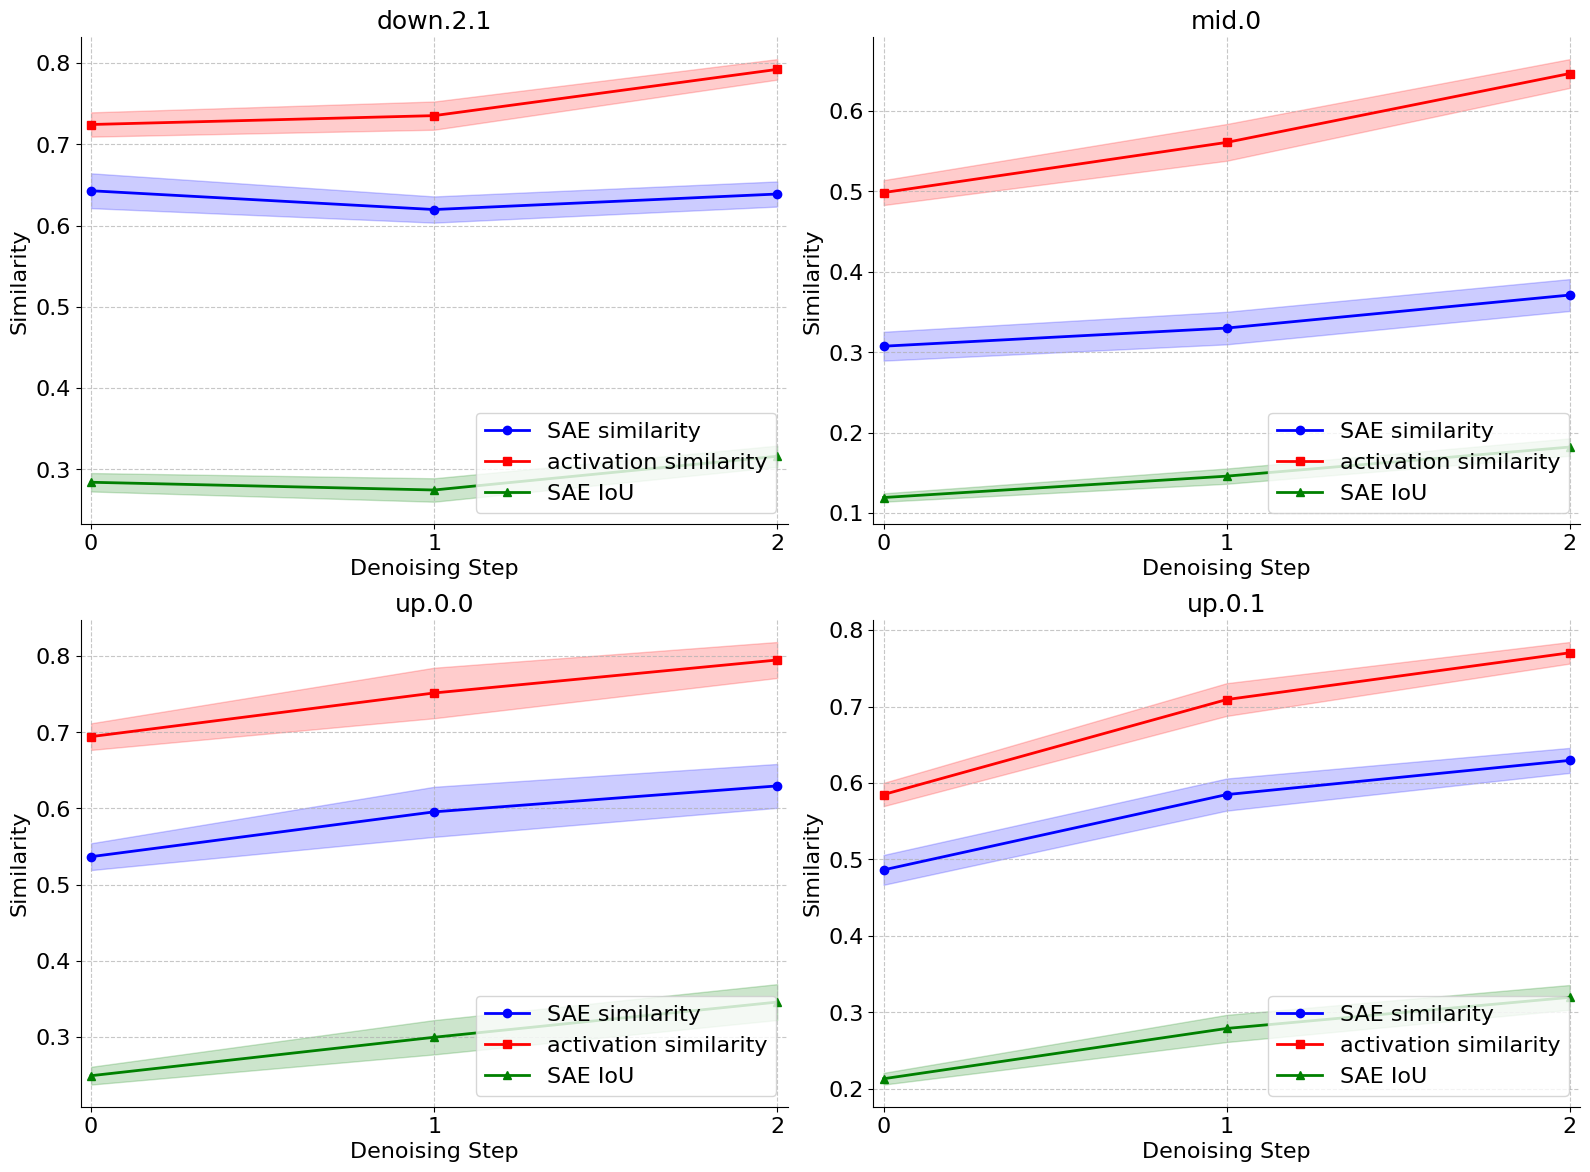

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Get unique block names
block_types = sorted(df['block'].unique())

# Get the number of cfg indices
if use_vanilla:
    cfg_indices = [0, 1]  # Assuming we have cfg_idx 0 and 1
else:
    cfg_indices = [0]

for cfg_idx in cfg_indices:
    # Create a grid of subplots for this cfg_idx
    n_blocks = len(block_types)
    n_cols = 2
    n_rows = (n_blocks + n_cols - 1) // n_cols  # Ceiling division
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 12))
    axes = axes.flatten()
    
    # Set common style parameters
    plt.rcParams['axes.spines.top'] = False
    plt.rcParams['axes.spines.right'] = False
    
    # Colors for different metrics
    colors = {'fdots': 'blue', 'dots': 'red', 'fdots_binarized': 'green'}
    
    for i, block_type in enumerate(block_types):
        if i >= len(axes):
            break
            
        # Filter data for this block type and cfg_idx
        block_data = df[df['block'] == block_type]
        
        # Group by tidx to get mean values
        tidx_groups = block_data.groupby('tidx')
        
        # Get unique tidx values and sort them, excluding the last datapoint which is a placeholder
        tidx_values = sorted(block_data['tidx'].unique())[:-1]  # Remove the last tidx (placeholder)
        
        # Get mean and std values for each tidx and metric, excluding the placeholder
        fdots_col = f"fdots_{cfg_idx}"
        dots_col = f"dots_{cfg_idx}"
        fdots_binarized_col = f"iou_{cfg_idx}"
        
        mean_fdots = [tidx_groups.get_group(tidx)[fdots_col].mean() for tidx in tidx_values]
        std_fdots = [tidx_groups.get_group(tidx)[fdots_col].std() / np.sqrt(len(tidx_groups.get_group(tidx))) for tidx in tidx_values]
        
        mean_dots = [tidx_groups.get_group(tidx)[dots_col].mean() for tidx in tidx_values]
        std_dots = [tidx_groups.get_group(tidx)[dots_col].std() / np.sqrt(len(tidx_groups.get_group(tidx))) for tidx in tidx_values]
        
        mean_fdots_binarized = [tidx_groups.get_group(tidx)[fdots_binarized_col].mean() for tidx in tidx_values]
        std_fdots_binarized = [tidx_groups.get_group(tidx)[fdots_binarized_col].std() / np.sqrt(len(tidx_groups.get_group(tidx))) for tidx in tidx_values]
        
        # Plot all three metrics with confidence intervals
        axes[i].plot(tidx_values, mean_fdots, 'o-', label='SAE similarity', linewidth=2, color=colors['fdots'])
        # Add Gaussian confidence interval: mean ± 1.96*std_error
        axes[i].fill_between(tidx_values, 
                             [m - 1.96*s for m, s in zip(mean_fdots, std_fdots)], 
                             [m + 1.96*s for m, s in zip(mean_fdots, std_fdots)], 
                             color=colors['fdots'], alpha=0.2)
        
        axes[i].plot(tidx_values, mean_dots, 's-', label='activation similarity', linewidth=2, color=colors['dots'])
        axes[i].fill_between(tidx_values, 
                             [m - 1.96*s for m, s in zip(mean_dots, std_dots)], 
                             [m + 1.96*s for m, s in zip(mean_dots, std_dots)], 
                             color=colors['dots'], alpha=0.2)
        
        
        # Only plot on the first axis if we're not using a second axis
        axes[i].plot(tidx_values, mean_fdots_binarized, '^-', label='SAE IoU', linewidth=2, color=colors['fdots_binarized'])
        axes[i].fill_between(tidx_values, 
                                [m - 1.96*s for m, s in zip(mean_fdots_binarized, std_fdots_binarized)], 
                                [m + 1.96*s for m, s in zip(mean_fdots_binarized, std_fdots_binarized)], 
                                color=colors['fdots_binarized'], alpha=0.2)
            
        # Add labels and title
        axes[i].set_title(f"{block_type}", fontsize=18)
        axes[i].set_xlabel("Denoising Step", fontsize=16)
        axes[i].set_ylabel("Similarity", fontsize=16)
        axes[i].grid(True, linestyle='--', alpha=0.7)
        
        # Add legend to all subplots
        axes[i].legend(fontsize=16, loc='lower right')
            
        axes[i].tick_params(axis='both', which='major', labelsize=16)
        
        # Set x-ticks to be exactly at the timestep indices
        axes[i].set_xticks(tidx_values)
        
        # Set xlim to be 0 and len(timesteps)-2
        axes[i].set_xlim(-0.03, len(tidx_values)-1+0.03)
    
    # Hide any unused subplots
    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)  # Make room for the suptitle
    plt.show()

In [19]:
sae.k

20